In [1]:
# basic numerical
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import pandas as pd

# nmf and sound
import nimfa
from sklearn.decomposition import NMF
import librosa

# disply
import IPython
from IPython.display import Audio
%matplotlib inline
%run test.py

/Users/Divir/miniconda2/envs/eecs352/lib/python2.7/site-packages/librosa/core/audio.py:37: UserWarning: Could not import scikits.samplerate. Falling back to scipy.signal
  warnings.warn('Could not import scikits.samplerate. '


In [2]:
# helper functions
def make_sinewave(f, t, sr):
    x = np.linspace(0, t, t*sr)
    y = np.sin(2*np.pi*f*x)
    return y

In [3]:
class AudioSeparator:
    def __init__(self, signal, num_sources, bases_per_source=5):
        self.signal = signal
        self.num_sources = num_sources
        self.bases_per_source = bases_per_source
        self.sgram = librosa.stft(self.signal)
        self.phi = np.angle(self.sgram)
    
    def nmf(self, V, k, precision = 0.001, max_iters = 100):
        '''Factorize a 2d matrix into two 2d matrices'''
        m, n = V.shape
        W, H = 1 + np.random.rand(m, k), 1 + np.random.rand(k, n)
        ones = np.ones(V.shape)
        eps = np.finfo(V.dtype).eps
        iters = 0

        while np.linalg.norm(V - np.dot(W, H)) / (V.size) > precision and iters < max_iters:
            W = W * np.dot(V / np.dot(W, H), H.T) / (np.dot(ones, H.T) + eps)
            H = H * np.dot(W.T, V / np.dot(W, H)) / (np.dot(W.T, ones) + eps)
            iters += 1

        # normalize W to sum to 1
        sumW = np.sum(W)
        diag1 = np.zeros((k, k))
        diag2 = np.zeros((k, k))
        np.fill_diagonal(diag1, 1. / sumW)
        np.fill_diagonal(diag2, sumW)
        W = np.dot(W, diag1)
        H = np.dot(diag2, H)
        return W, H
    
    def get_features(self, W, H, phi):
        '''Calculate MFCC features of each basis vector of W * H'''
        n, k = W.shape
        _, m = H.shape
        features = []
        mfccs = []

        # reconstruct each basis as a separate source
        for i in xrange(k):
            V = np.dot(np.reshape(W[:, i], (n, 1)), np.reshape(H[i, :], (1, m)))
            # add phase information
            V = V * np.exp(1j * phi)
            x = librosa.istft(V)
            # calculate mfcc features
            mfcc = librosa.feature.mfcc(y=x, sr=self.sr)
            mfcc = (mfcc - mfcc.mean(axis=0)) / mfcc.std(axis=0)
            mfccs.append(mfcc)
            stats = np.concatenate((np.mean(mfcc, axis=1), np.std(mfcc, axis=1)))
            features.append(stats)
            
        mfccs = np.array(mfccs)
        features = sp.cluster.vq.whiten(np.array(features)) # normalize to unit variance 
        return features, mfccs
    
    def cluster_basis(self, features, num_sources):
        '''Cluster using k-means. Features is a 2d array where 
        each row is a data point and each column is a feature.'''
        centroids, labels = sp.cluster.vq.kmeans2(features, num_sources)
        # labels, _ = vq(features, centroids)
        return labels
    
    def split_spectogram(self, V, num_sources, plot_basis_spectograms):
        '''Slipt a spectogram into multiple spectograms, one for each source'''
        V_sources = []
        # NMF
        k = self.bases_per_source * num_sources
        if self.nmf_src == 'sklearn':
            model = NMF(n_components=k, init='random', random_state=0)
            W, H = model.fit_transform(V), model.fit(V).components_
        elif self.nmf_src == 'nimfa':
            nmf_model = nimfa.Nmf(V, seed="nndsvd", rank=k, max_iter=200, update='euclidean', objective='fro')
            nmf_fit = nmf_model()
            W, H = np.array(nmf_fit.basis()), np.array(nmf_fit.coef())
        else:
            W, H = self.nmf(V, k)

        # features
        features, mfccs = self.get_features(W, H, self.phi)
        # indices from clustering basis spectograms
        labels = self.cluster_basis(features, num_sources)
        # form spectograms
        V_sources = [np.dot(W[:, labels == i], H[labels == i, :]) for i in xrange(num_sources)]
        V_sources = np.array(V_sources * np.exp(1j * self.phi))
        V_hat = np.dot(W, H) * np.exp(1j * self.phi)
        
        if plot_basis_spectograms:
            self.plot_basis_spectograms(W, H, labels, mfccs)
        return V_sources, V_hat
    
    def plot_source_spectograms(self, V, V_hat, V_sources):
        '''Plot original and recover spectograms'''
        plt.figure(figsize=(16,4)) 
        plt.suptitle('Complete spectrograms', fontsize=16)
        ax = plt.subplot(121)
        ax.set_title('Original')
        self.plot_spectogram(V)
        ax = plt.subplot(122)
        ax.set_title('Recovered')
        self.plot_spectogram(V_hat)
        plt.show();
        
        plt.figure(figsize=(16,4))
        n = len(V_sources)
        plt.suptitle('Source spectrograms', fontsize=16)
        for i in xrange(n):
            ax = plt.subplot(1, n, i+1)
            ax.set_title('Source %d' % (i+1))
            self.plot_spectogram(V_sources[i])
        plt.show();
        return
    
    def plot_basis_spectograms(self, W, H, labels, mfccs):
        '''Plot each basis spectogram and the corresponding MFCC coefficients'''
        n, k = W.shape
        _, m = H.shape
        
        # plot spectogams
        plt.figure(figsize=(16,6))
        plt.suptitle('Bases spectrograms', fontsize=16)
        for i in xrange(k):
            ax = plt.subplot(self.num_sources, self.bases_per_source, i+1)
            ax.set_title('Basis %d, Source: %d' % (i+1, labels[i]))
            V = np.dot(np.reshape(W[:, i], (n, 1)), np.reshape(H[i, :], (1, m)))
            self.plot_spectogram(V)
        plt.show();
    
        # plot mfccs
        plt.figure(figsize=(16,6))
        plt.suptitle('Bases MFCCs', fontsize=16)
        for i in xrange(k):
            ax = plt.subplot(self.num_sources, self.bases_per_source, i+1)
            ax.set_title('Basis %d, Source: %d' % (i+1, labels[i]))
            self.plot_spectogram(mfccs[i])
        plt.show();
        return
    
    def spectograms_to_signals(self, V_sources):
        '''Convert spectograms to audio signals and zero extend to orignal signal length'''
        signals = [librosa.istft(V) for V in V_sources]
        # zero extend
        signals = np.array([np.append(x, [0] * (self.signal.size - x.size)) for x in signals])
        return signals
    
    def plot_spectogram(self, V):
        '''Plot power spectogram using librosa'''
        librosa.display.specshow(librosa.logamplitude(V**2, ref_power=np.max))
        return
    
    def plot_audio(self, original, signals, sr):
        '''Plot signals using librosa'''
        time = np.linspace(0, len(original) / sr, num=len(original))
        plt.figure(figsize=(16,4))
        n = len(signals) + 1
        plt.suptitle('Source signals', fontsize=16)
        ax = plt.subplot(1, n, 1)
        ax.set_title('Original')
        ax.plot(time, original)
        for i in xrange(len(signals)):
            ax = plt.subplot(1, n, i+2)
            ax.set_title('Source %d' % (i+1))
            ax.plot(time, signals[i])
        plt.show();
        return
    
    def play_audio(self, original, signals, sr):
        '''Play audio signals'''
        n = len(signals) + 1
        print 'Original signal'
        IPython.display.display(Audio(original, rate=sr))
        for i, x in enumerate(signals):
            print 'Source %d' % (i+1)
            IPython.display.display(Audio(x, rate=sr))
        return
    
    def performance(self, source_names, original_sources):
        '''Return a Pandas table with SDR, SIR and SAR evaluation results'''
        scores = bss_eval_sources(original_sources, self.estimated_sources)
        scores, perm = np.array(scores[:-1]), scores[-1]
        # match source name to the estimates sources
        col_names = [x for (_, x) in sorted(zip(perm, source_names))]
        print 'Source to intstrument matches'
        source_perm = ['Source %d' % (i+1) for i in perm]
        print dict(zip(source_perm, source_names)), '\n'
        df = pd.DataFrame(data=scores, index=['sdr', 'sir', 'sar'], columns=source_names)
        # add row and column means
        df.loc['avg'] = df.mean(axis=0)
        df['avg'] = df.mean(axis=1)
        print 'Performace'
        IPython.display.display(df)
        return df

    def split(self, sr=44100., plot_source_spectograms=True, plot_basis_spectograms=False, 
              plot_audio=True, play_audio=True, nmf_src='custom'):
        '''Split the signal into sources'''
        self.nmf_src = nmf_src
        self.sr = sr
        V = np.abs(self.sgram)
        V_sources, V_hat = self.split_spectogram(V, self.num_sources, plot_basis_spectograms)
        self.estimated_sources = self.spectograms_to_signals(V_sources)
        
        # plots
        if plot_source_spectograms:
            self.plot_source_spectograms(V, V_hat, V_sources)
        if plot_audio:
            self.plot_audio(self.signal, self.estimated_sources, sr)
        if play_audio:
            self.play_audio(self.signal, self.estimated_sources, sr)
        return self.estimated_sources
    
def load_audio(names, duration=10):
    instruments = {}
    for name in names:
        signal, sr = librosa.load('input/%s.wav' % name, sr=44100., duration=duration, mono=True)
        instruments[name] = signal
    return instruments

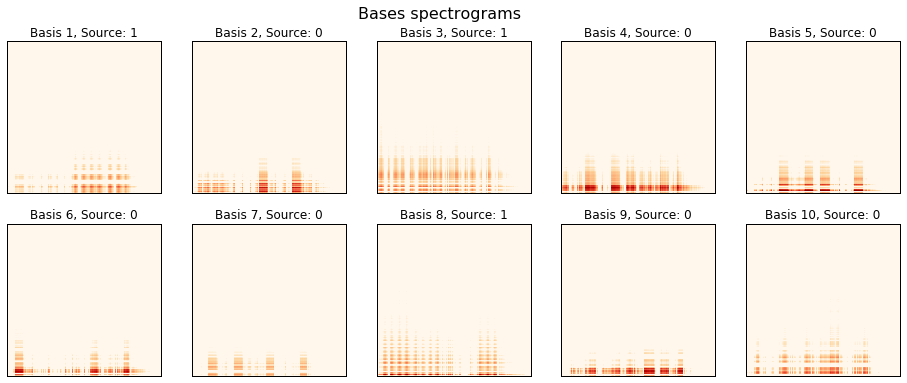

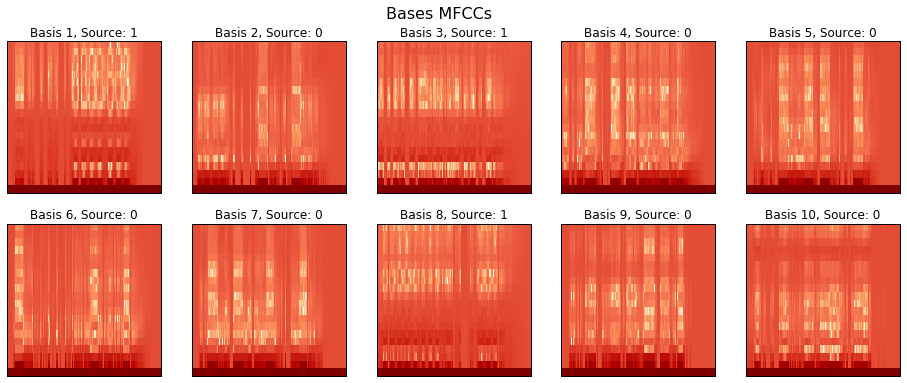

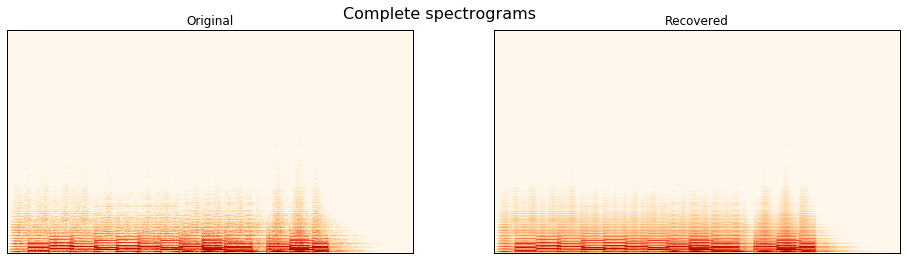

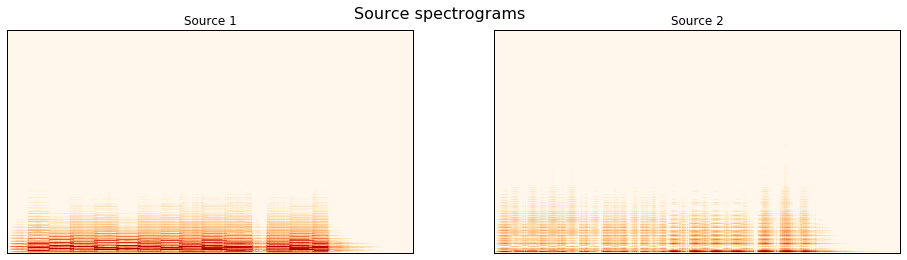

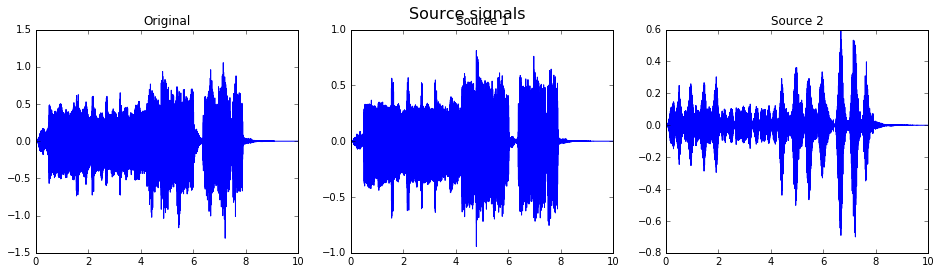

Original signal


Source 1


Source 2


Source to intstrument matches
{'Source 2': 'violin', 'Source 1': 'piano'} 

Performace


piano     violin        avg
sdr  12.506553   8.475398  10.490976
sir  15.748802  13.168473  14.458637
sar  15.410742  10.480404  12.945573
avg  14.555365  10.708092  12.631729

In [4]:
# create signal
instruments = load_audio(['drums', 'electricpiano', 'percussion', 'piano', 'strings', 'trumpet', 'violin'])
source_names = ['piano', 'violin']
original_sources = np.array([instruments[name] for name in source_names])
signal = np.sum(original_sources, axis=0)

# run separator and evaluate results
separator = AudioSeparator(signal, num_sources=2)
estimated_sources = separator.split(plot_basis_spectograms=True)
scores = separator.performance(source_names, original_sources)

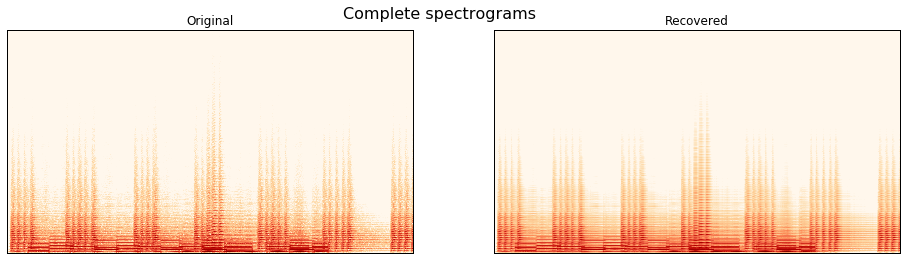

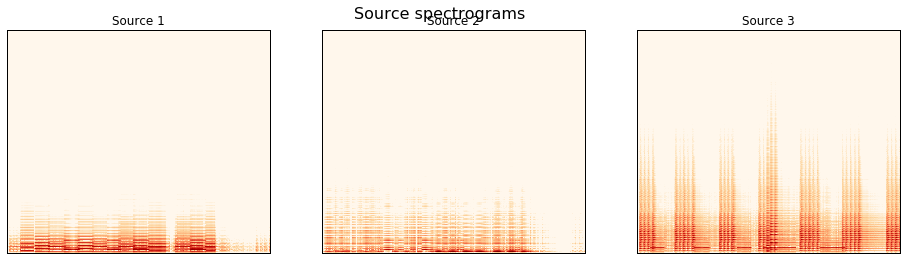

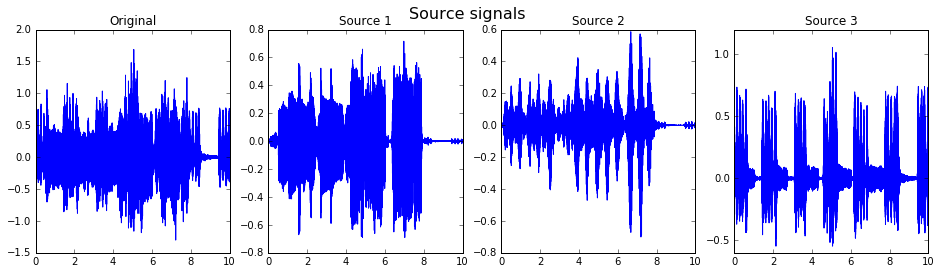

Original signal


Source 1


Source 2


Source 3


Source to intstrument matches
{'Source 3': 'trumpet', 'Source 2': 'violin', 'Source 1': 'piano'} 

Performace


piano     violin   trumpet        avg
sdr  10.684740   6.947506  5.650381   7.760876
sir  15.852831   9.864829  8.453002  11.390221
sar  12.371443  10.479208  9.458459  10.769703
avg  12.969671   9.097181  7.853947   9.973600

In [5]:
source_names = ['piano', 'violin', 'trumpet']
original_sources = np.array([instruments[name] for name in source_names])
signal = np.sum(original_sources, axis=0)

# run separator and evaluate results
separator = AudioSeparator(signal, num_sources=3)
estimated_sources = separator.split()
scores = separator.performance(source_names, original_sources)